## Assignment  no: 3
## Your name: Huda Aisyah Khoirunissa          student ID: 1144833
### When you use code, either from another student or an outside source, you should cite it. Tell me where the code comes from.
#### (v)  1. I Totally write by myself (都自己寫)
#### ( ) 2. Refer to other students (參考同學,註明姓名學號):   name and student id
#### ( ) 3. Refer to outside sources (參考外部資料網站), where:
## If you choose 2 or 3, tell me how similar you are. (如果選2,3, 請勾選相似程度)
#### ( ) < 25% ( ) 25%..50% ( ) 50%..75% (  ) > 75%
### Give me your expected score (給我你的期望分數): 87
### Reasons (理由): I explored the project independently, experimenting with different network configurations and hyperparameters. I also worked on structuring the logic of my code, even though at the beginning I faced errors and forgot some parts. Through trial and error, I managed to fix these issues and better understand how hyperparameters, schedulers, and architectures affect performance. This hands-on process helped me deepen my understanding of model training and generalization, and I think a score of 87 is fair.

## If you use AI, you must clearly state what AI was used for and how it was used in your submission. Answer the following questions: (若有使用AI, 需說明AI使用的內容與方式, 回答底下問題)
- The tool you used (使用的AI工具名稱): ChatGPT 5
- How you used it (lookup / debugging / code snippet) (使用的方式): Debugging and refactoring; generated small code snippets for looping experiments and building summary tables.
- How you modified and understood the result (修改與理解過程): I parameterized the model (hidden_sizes, activations), built a loop to run 20-epoch SGD experiments with and without ReduceLROnPlateau, and compared ReLU vs. LeakyReLU (since I’ve used both before and wanted to see their performance side-by-side) and created a summary table to highlight the best test accuracy.

## 說明與心得 explain your code briefly, tell me something, and share your experience.

In this project, I explored different network configurations by varying hidden layers, neurons per layer, activation functions (ReLU vs. LeakyReLU), and training with or without a learning rate scheduler. I imported the required libraries, downloaded the FashionMNIST dataset from pytorch package, and implemented a parameterized neural network class so I could loop through multiple architectures efficiently. Training was handled by train_loop_experiment (which sets the model in .train() mode, computes forward pass, loss, backward pass, and optimizer step), while eval_loop_experiment runs in .eval() with torch.no_grad() to measure test loss and accuracy. The experiments were run on GPU (CUDA) for faster training. I used ReduceLROnPlateau because it lowers the learning rate when test loss plateaus, helping the optimizer escape stuck regions and converge more effectively. This often improved test accuracy compared to not using a scheduler. Results showed that all models exhibited some degree of overfitting (train accuracy > test accuracy, and sometimes test loss rising even while train loss decreased). Still, LeakyReLU with a scheduler gave the best overall accuracy. Schedulers consistently improved generalization, though deeper models also increased the risk of overfitting.

From the experiments, I observed that models with more layers and neurons reached higher train accuracy but also overfitted more. The scheduler consistently improved stability and test accuracy, especially with LeakyReLU, which handled negative activations better than ReLU. My experience showed that while deeper models can achieve strong results, balancing capacity and regularization is key for generalization.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [16]:
import numpy as np

In [2]:
import pandas as pd

In [11]:
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

Using cuda


In [8]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self,
                 input_size: int = 28*28,
                 hidden_sizes = [512, 512],
                 activations = nn.ReLU,        
                 num_classes: int = 10):
        super().__init__()
        self.flatten = nn.Flatten()

        if callable(activations):
            act_list = [activations for _ in hidden_sizes]
        else:
            if len(activations) != len(hidden_sizes):
                raise ValueError("If 'activations' is a list, its length must match 'hidden_sizes'.")
            act_list = activations

        layers = []
        in_features = input_size

        for h, act in zip(hidden_sizes, act_list):
            layers.append(nn.Linear(in_features, h))
            layers.append(act())
            in_features = h

        layers.append(nn.Linear(in_features, num_classes))

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)


In [6]:
def train_loop_experiment(dataloader, model, loss_fn, optimizer, device="cpu"):
    model.train()
    total_loss, correct, n = 0.0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == y).sum().item()
        n += y.size(0)
    return total_loss/len(dataloader), correct/n

@torch.no_grad()
def eval_loop_experiment(dataloader, model, loss_fn, device="cpu"):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    all_preds, all_targets = [], []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        total_loss += loss_fn(logits, y).item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        n += y.size(0)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())
    return total_loss/len(dataloader), correct/n, torch.cat(all_preds), torch.cat(all_targets)


### LeakyReLU

In [9]:
EPOCHS, LR, MOM = 20, 0.1, 0.9
device = "cuda" if torch.cuda.is_available() else "cpu"

arch_configs = {
    "1HL-128-LReLU":               dict(hidden_sizes=[128], activations=nn.LeakyReLU),
    "2HL-256-128-LReLU":           dict(hidden_sizes=[256,128], activations=nn.LeakyReLU),
    "3HL-512-256-128-LReLU":       dict(hidden_sizes=[512,256,128], activations=nn.LeakyReLU),
    "4HL-512-256-128-64-LReLU":    dict(hidden_sizes=[512,256,128,64], activations=nn.LeakyReLU),
}

def run_scheduler(use_scheduler: bool):
    results = {}
    for name, cfg in arch_configs.items():
        torch.manual_seed(0)

        model = NeuralNetwork(**cfg).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = SGD(model.parameters(), lr=LR, momentum=MOM)
        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3) if use_scheduler else None

        hist = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[]}
        for ep in range(EPOCHS):
            tr_loss, tr_acc = train_loop_experiment(train_dataloader, model, loss_fn, optimizer, device)
            tst_loss, tst_acc, y_pred, y_true = eval_loop_experiment(test_dataloader, model, loss_fn, device)
            if scheduler: scheduler.step(tst_loss)
            hist["train_loss"].append(tr_loss)
            hist["test_loss"].append(tst_loss)
            hist["train_acc"].append(tr_acc)
            hist["test_acc"].append(tst_acc)

            if ep == 0:
                tag = "Plateau" if use_scheduler else "NoScheduler"
                print(f"=== {name} [{tag}] ===")
            print(f"Ep{ep+1:02d} | tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | tst_loss={tst_loss:.4f} tst_acc={tst_acc:.4f}")

        key = f"{name}-{'Plateau' if use_scheduler else 'NoScheduler'}"
        results[key] = hist
    return results

results_nosched = run_scheduler(use_scheduler=False)
results_plateau = run_scheduler(use_scheduler=True)

=== 1HL-128-LReLU [NoScheduler] ===
Ep01 | tr_loss=0.5937 tr_acc=0.7879 | tst_loss=0.5725 tst_acc=0.8000
Ep02 | tr_loss=0.4894 tr_acc=0.8197 | tst_loss=0.5376 tst_acc=0.8159
Ep03 | tr_loss=0.4446 tr_acc=0.8384 | tst_loss=0.4684 tst_acc=0.8261
Ep04 | tr_loss=0.4154 tr_acc=0.8491 | tst_loss=0.4776 tst_acc=0.8386
Ep05 | tr_loss=0.3956 tr_acc=0.8561 | tst_loss=0.4371 tst_acc=0.8476
Ep06 | tr_loss=0.3786 tr_acc=0.8615 | tst_loss=0.4224 tst_acc=0.8550
Ep07 | tr_loss=0.3664 tr_acc=0.8647 | tst_loss=0.4182 tst_acc=0.8563
Ep08 | tr_loss=0.3548 tr_acc=0.8692 | tst_loss=0.4170 tst_acc=0.8567
Ep09 | tr_loss=0.3463 tr_acc=0.8704 | tst_loss=0.4159 tst_acc=0.8520
Ep10 | tr_loss=0.3357 tr_acc=0.8749 | tst_loss=0.4366 tst_acc=0.8587
Ep11 | tr_loss=0.3256 tr_acc=0.8781 | tst_loss=0.4300 tst_acc=0.8583
Ep12 | tr_loss=0.3228 tr_acc=0.8799 | tst_loss=0.4539 tst_acc=0.8538
Ep13 | tr_loss=0.3119 tr_acc=0.8837 | tst_loss=0.4532 tst_acc=0.8548
Ep14 | tr_loss=0.3071 tr_acc=0.8850 | tst_loss=0.4275 tst_acc=0.863

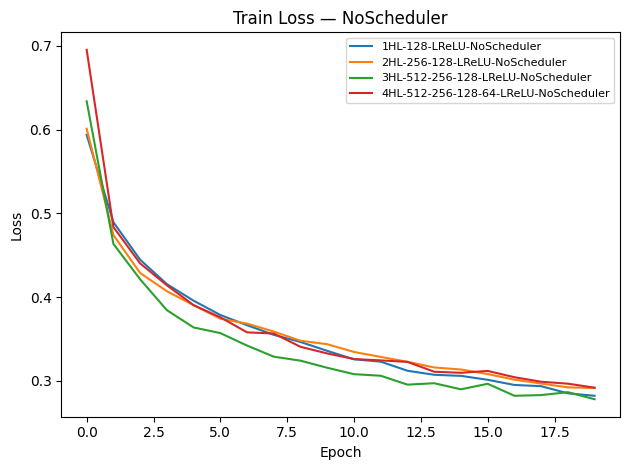

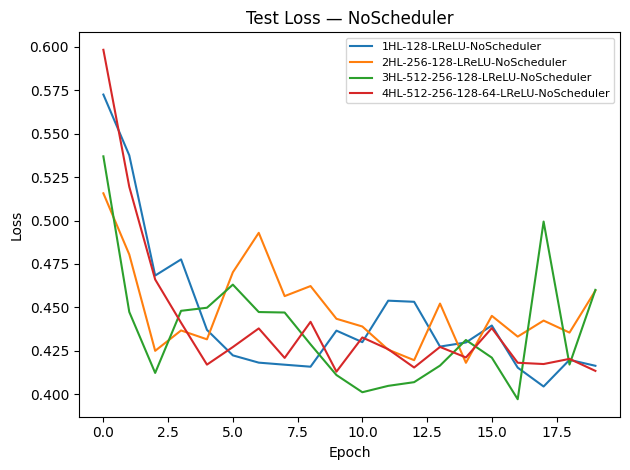

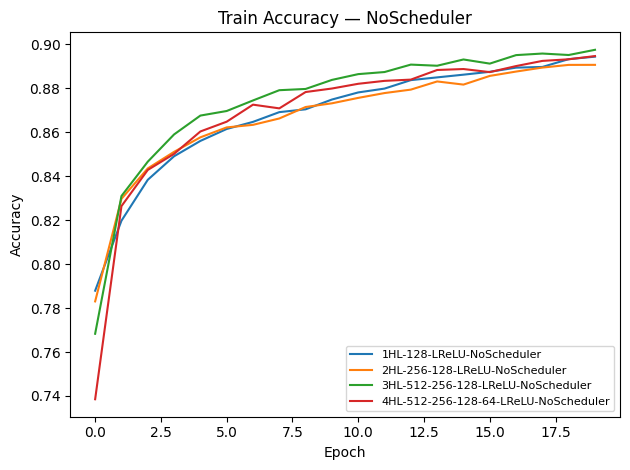

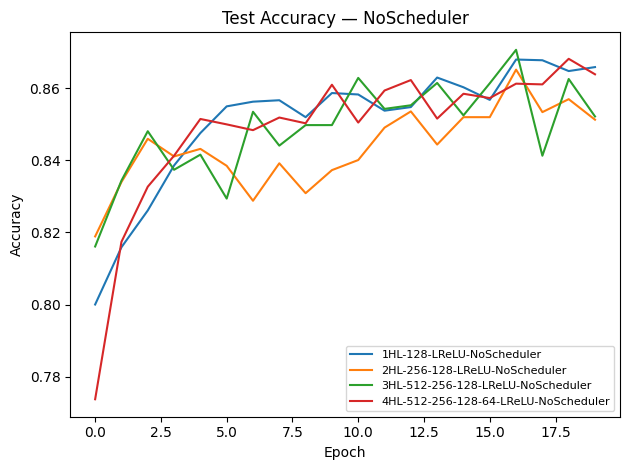

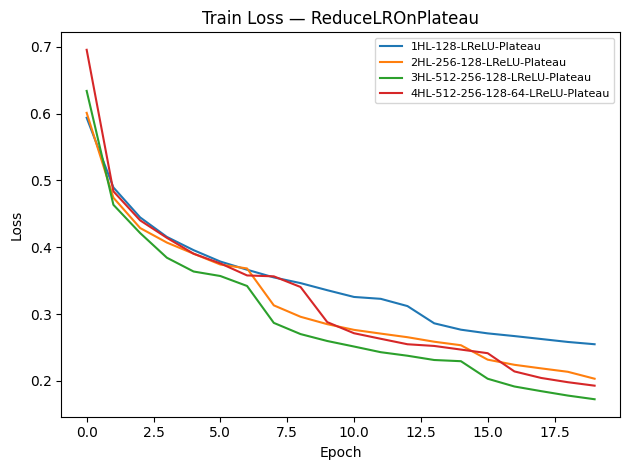

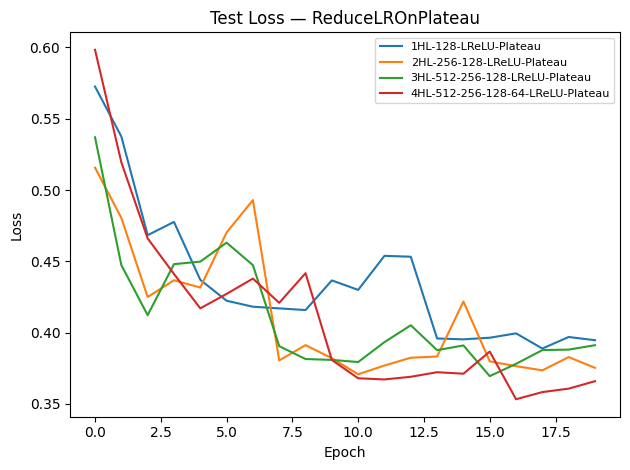

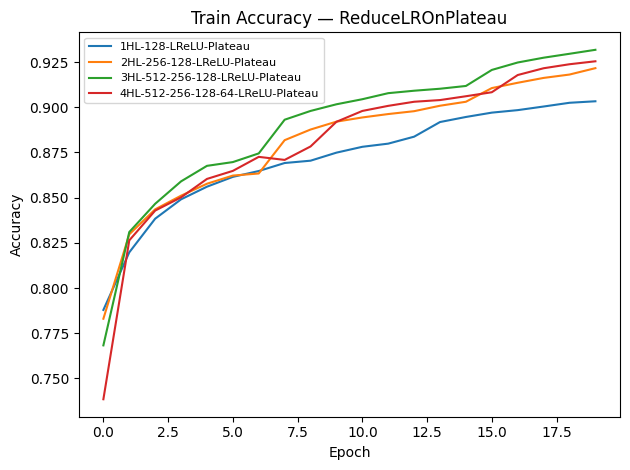

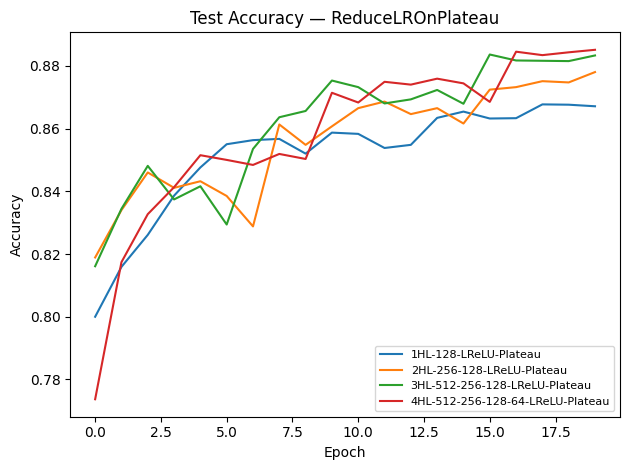

In [12]:
def overlay(results_dict, key, title, ylabel):
    plt.figure()
    for name, h in results_dict.items():
        plt.plot(h[key], label=name)
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(ylabel)
    plt.legend(fontsize=8); plt.tight_layout(); plt.show()

# NoScheduler
overlay(results_nosched, "train_loss", "Train Loss — NoScheduler", "Loss")
overlay(results_nosched, "test_loss",  "Test Loss — NoScheduler",  "Loss")
overlay(results_nosched, "train_acc",  "Train Accuracy — NoScheduler", "Accuracy")
overlay(results_nosched, "test_acc",   "Test Accuracy — NoScheduler",  "Accuracy")

# Plateau
overlay(results_plateau, "train_loss", "Train Loss — ReduceLROnPlateau", "Loss")
overlay(results_plateau, "test_loss",  "Test Loss — ReduceLROnPlateau",  "Loss")
overlay(results_plateau, "train_acc",  "Train Accuracy — ReduceLROnPlateau", "Accuracy")
overlay(results_plateau, "test_acc",   "Test Accuracy — ReduceLROnPlateau",  "Accuracy")

In [13]:
def summary_df(results_dict):
    rows = []
    for name, h in results_dict.items():
        rows.append({
            "Config": name,
            "Final Train Acc": h["train_acc"][-1],
            "Final Test Acc":  h["test_acc"][-1],
            "Final Test Loss": h["test_loss"][-1],
        })
    return pd.DataFrame(rows).sort_values("Final Test Acc", ascending=False)

print("\nSummary: NoScheduler")
df_nosched = summary_df(results_nosched)
print(df_nosched.to_string(index=False))
best_nosched = df_nosched.iloc[0]
print(f"\nBest (NoScheduler) → {best_nosched['Config']} | Test Acc={best_nosched['Final Test Acc']:.4f}")

print("\nSummary: ReduceLROnPlateau")
df_plateau = summary_df(results_plateau)
print(df_plateau.to_string(index=False))
best_plateau = df_plateau.iloc[0]
print(f"\nBest (Plateau) → {best_plateau['Config']} | Test Acc={best_plateau['Final Test Acc']:.4f}")

df_combined = pd.concat([
    df_nosched.assign(Scheduler="NoScheduler"),
    df_plateau.assign(Scheduler="Plateau")
], ignore_index=True).sort_values("Final Test Acc", ascending=False)
print("\n=== Summary: Combined (sorted by Final Test Acc) ===")
print(df_combined.to_string(index=False))

overall_best = df_combined.iloc[0]
print(f"\nOverall Best → {overall_best['Config']} [{overall_best['Scheduler']}] "
      f"| Test Acc={overall_best['Final Test Acc']:.4f}")



Summary: NoScheduler
                              Config  Final Train Acc  Final Test Acc  Final Test Loss
           1HL-128-LReLU-NoScheduler         0.894417          0.8659         0.416391
4HL-512-256-128-64-LReLU-NoScheduler         0.894683          0.8639         0.413460
   3HL-512-256-128-LReLU-NoScheduler         0.897533          0.8522         0.460105
       2HL-256-128-LReLU-NoScheduler         0.890683          0.8513         0.459667

Best (NoScheduler) → 1HL-128-LReLU-NoScheduler | Test Acc=0.8659

Summary ReduceLROnPlateau
                          Config  Final Train Acc  Final Test Acc  Final Test Loss
4HL-512-256-128-64-LReLU-Plateau         0.925433          0.8851         0.365979
   3HL-512-256-128-LReLU-Plateau         0.931783          0.8833         0.391221
       2HL-256-128-LReLU-Plateau         0.921633          0.8780         0.375351
           1HL-128-LReLU-Plateau         0.903317          0.8671         0.394718

Best (Plateau) → 4HL-512-256-128-6

### ReLU 

In [24]:
EPOCHS, LR, MOM = 20, 0.1, 0.9
device = "cuda" if torch.cuda.is_available() else "cpu"

arch_configs = {
    "1HL-128-ReLU":               dict(hidden_sizes=[128], activations=nn.ReLU),
    "2HL-256-128-ReLU":           dict(hidden_sizes=[256,128], activations=nn.ReLU),
    "3HL-512-256-128-ReLU":       dict(hidden_sizes=[512,256,128], activations=nn.ReLU),
    "4HL-512-256-128-64-ReLU":    dict(hidden_sizes=[512,256,128,64], activations=nn.ReLU),
}

def run_scheduler(use_scheduler: bool):
    results = {}
    for name, cfg in arch_configs.items():
        torch.manual_seed(0)

        model = NeuralNetwork(**cfg).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = SGD(model.parameters(), lr=LR, momentum=MOM)
        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3) if use_scheduler else None

        hist = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[]}
        for ep in range(EPOCHS):
            tr_loss, tr_acc = train_loop_experiment(train_dataloader, model, loss_fn, optimizer, device)
            tst_loss, tst_acc, y_pred, y_true = eval_loop_experiment(test_dataloader, model, loss_fn, device)
            if scheduler: scheduler.step(tst_loss)
            hist["train_loss"].append(tr_loss)
            hist["test_loss"].append(tst_loss)
            hist["train_acc"].append(tr_acc)
            hist["test_acc"].append(tst_acc)

            if ep == 0:
                tag = "Plateau" if use_scheduler else "NoScheduler"
                print(f"=== {name} [{tag}] ===")
            print(f"Ep{ep+1:02d} | tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | tst_loss={tst_loss:.4f} tst_acc={tst_acc:.4f}")

        key = f"{name}-{'Plateau' if use_scheduler else 'NoScheduler'}"
        results[key] = hist
    return results

results_nosched = run_scheduler(use_scheduler=False)
results_plateau = run_scheduler(use_scheduler=True)

=== 1HL-128-ReLU [NoScheduler] ===
Ep01 | tr_loss=0.6013 tr_acc=0.7845 | tst_loss=0.5269 tst_acc=0.8183
Ep02 | tr_loss=0.4947 tr_acc=0.8202 | tst_loss=0.5595 tst_acc=0.8084
Ep03 | tr_loss=0.4595 tr_acc=0.8338 | tst_loss=0.4965 tst_acc=0.8223
Ep04 | tr_loss=0.4321 tr_acc=0.8435 | tst_loss=0.4548 tst_acc=0.8444
Ep05 | tr_loss=0.4211 tr_acc=0.8492 | tst_loss=0.4650 tst_acc=0.8395
Ep06 | tr_loss=0.4062 tr_acc=0.8564 | tst_loss=0.4858 tst_acc=0.8353
Ep07 | tr_loss=0.3934 tr_acc=0.8599 | tst_loss=0.4762 tst_acc=0.8411
Ep08 | tr_loss=0.3904 tr_acc=0.8609 | tst_loss=0.4812 tst_acc=0.8391
Ep09 | tr_loss=0.3772 tr_acc=0.8642 | tst_loss=0.4624 tst_acc=0.8511
Ep10 | tr_loss=0.3694 tr_acc=0.8670 | tst_loss=0.4469 tst_acc=0.8472
Ep11 | tr_loss=0.3669 tr_acc=0.8678 | tst_loss=0.4677 tst_acc=0.8463
Ep12 | tr_loss=0.3590 tr_acc=0.8706 | tst_loss=0.4894 tst_acc=0.8444
Ep13 | tr_loss=0.3738 tr_acc=0.8625 | tst_loss=0.4938 tst_acc=0.8368
Ep14 | tr_loss=0.3502 tr_acc=0.8712 | tst_loss=0.4914 tst_acc=0.8410

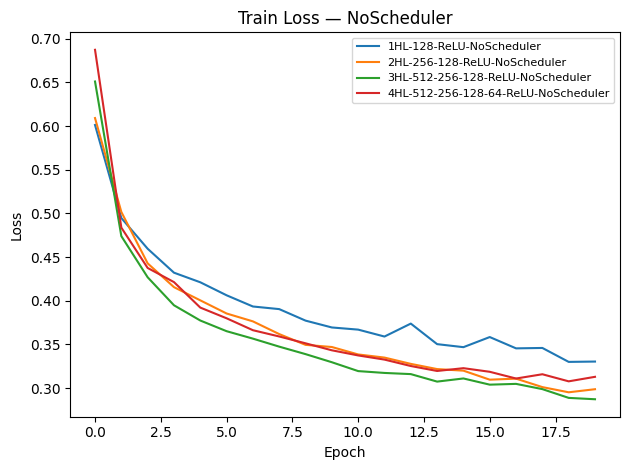

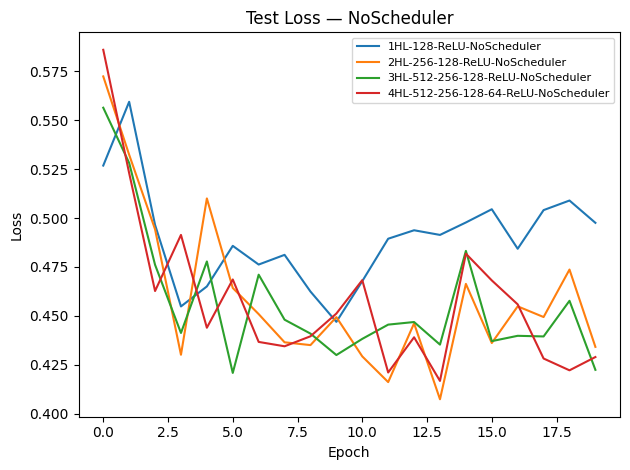

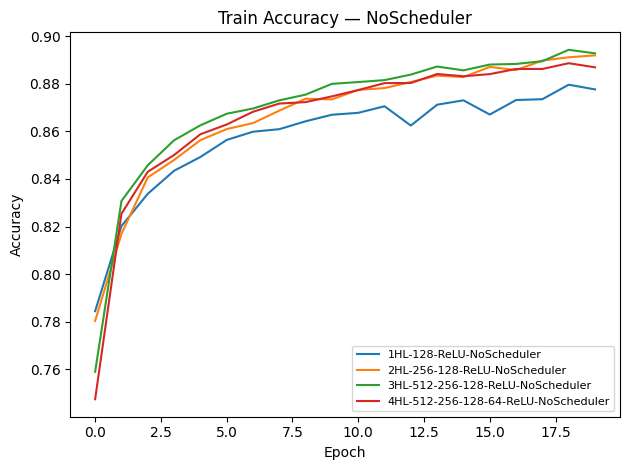

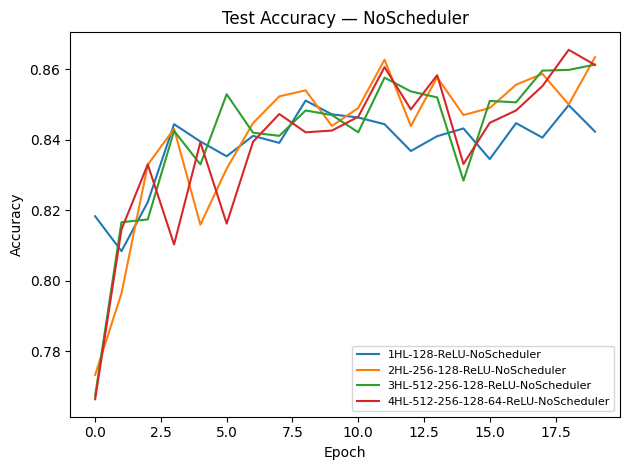

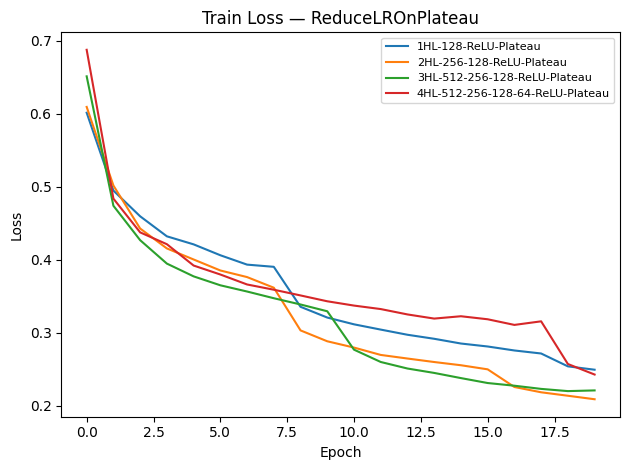

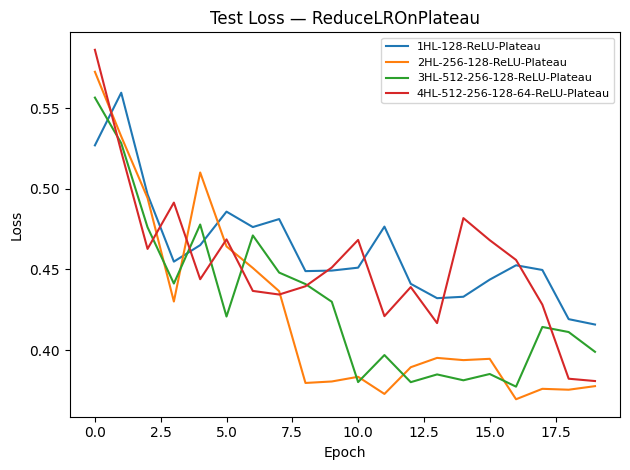

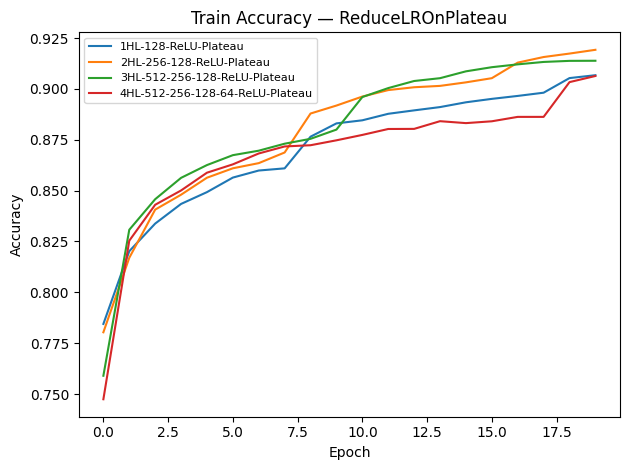

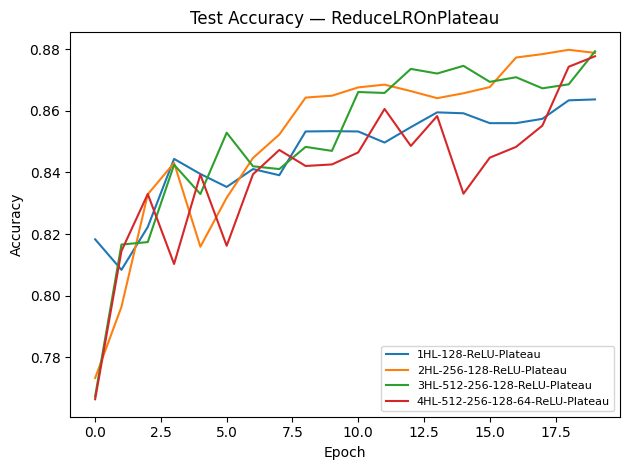

In [25]:
def overlay(results_dict, key, title, ylabel):
    plt.figure()
    for name, h in results_dict.items():
        plt.plot(h[key], label=name)
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(ylabel)
    plt.legend(fontsize=8); plt.tight_layout(); plt.show()

# NoScheduler
overlay(results_nosched, "train_loss", "Train Loss — NoScheduler", "Loss")
overlay(results_nosched, "test_loss",  "Test Loss — NoScheduler",  "Loss")
overlay(results_nosched, "train_acc",  "Train Accuracy — NoScheduler", "Accuracy")
overlay(results_nosched, "test_acc",   "Test Accuracy — NoScheduler",  "Accuracy")

# Plateau
overlay(results_plateau, "train_loss", "Train Loss — ReduceLROnPlateau", "Loss")
overlay(results_plateau, "test_loss",  "Test Loss — ReduceLROnPlateau",  "Loss")
overlay(results_plateau, "train_acc",  "Train Accuracy — ReduceLROnPlateau", "Accuracy")
overlay(results_plateau, "test_acc",   "Test Accuracy — ReduceLROnPlateau",  "Accuracy")

In [26]:
def summary_df(results_dict):
    rows = []
    for name, h in results_dict.items():
        rows.append({
            "Config": name,
            "Final Train Acc": h["train_acc"][-1],
            "Final Test Acc":  h["test_acc"][-1],
            "Final Test Loss": h["test_loss"][-1],
        })
    return pd.DataFrame(rows).sort_values("Final Test Acc", ascending=False)

print("\nSummary: NoScheduler")
df_nosched = summary_df(results_nosched)
print(df_nosched.to_string(index=False))
best_nosched = df_nosched.iloc[0]
print(f"\nBest (NoScheduler) → {best_nosched['Config']} | Test Acc={best_nosched['Final Test Acc']:.4f}")

print("\nSummary: ReduceLROnPlateau")
df_plateau = summary_df(results_plateau)
print(df_plateau.to_string(index=False))
best_plateau = df_plateau.iloc[0]
print(f"\nBest (Plateau) → {best_plateau['Config']} | Test Acc={best_plateau['Final Test Acc']:.4f}")

df_combined = pd.concat([
    df_nosched.assign(Scheduler="NoScheduler"),
    df_plateau.assign(Scheduler="Plateau")
], ignore_index=True).sort_values("Final Test Acc", ascending=False)
print("\n=== Summary: Combined (sorted by Final Test Acc) ===")
print(df_combined.to_string(index=False))

overall_best = df_combined.iloc[0]
print(f"\nOverall Best → {overall_best['Config']} [{overall_best['Scheduler']}] "
      f"| Test Acc={overall_best['Final Test Acc']:.4f}")



Summary: NoScheduler
                             Config  Final Train Acc  Final Test Acc  Final Test Loss
       2HL-256-128-ReLU-NoScheduler         0.891950          0.8634         0.434100
   3HL-512-256-128-ReLU-NoScheduler         0.892800          0.8613         0.422358
4HL-512-256-128-64-ReLU-NoScheduler         0.886933          0.8612         0.428902
           1HL-128-ReLU-NoScheduler         0.877650          0.8423         0.497564

Best (NoScheduler) → 2HL-256-128-ReLU-NoScheduler | Test Acc=0.8634

Summary: ReduceLROnPlateau
                         Config  Final Train Acc  Final Test Acc  Final Test Loss
   3HL-512-256-128-ReLU-Plateau         0.913817          0.8793         0.398907
       2HL-256-128-ReLU-Plateau         0.919200          0.8788         0.377628
4HL-512-256-128-64-ReLU-Plateau         0.906333          0.8777         0.380788
           1HL-128-ReLU-Plateau         0.906717          0.8637         0.415812

Best (Plateau) → 3HL-512-256-128-ReLU-Pl